In [1]:
import os
import json
from google.colab import drive

import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.metrics as confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

# Configuración de google drive

In [2]:
# Montar google drive
drive.mount('/content/drive')

# Cambiar de directorio raiz
ROOT_DIR = '/content/drive/MyDrive/skin-cancer'
os.chdir(ROOT_DIR)

Mounted at /content/drive


# Datos para el entrenamiento

Se lee el archivo HAM10000_metadata_augmented, el cual contiene los metadatos del conjunto de datos balanceado. También se almancena en una lista, las clases con los diferentes tipos de lesiones de piel.

Vamos a crear una lista (clases) con los diferentes tipos de lesiones de la piel que vamos a clasificar

In [3]:
balanced_dataset = pd.read_csv('/content/drive/MyDrive/skin-cancer/HAM10000_metadata_augmented')

df_metadata = balanced_dataset
df_metadata.head()

,Unnamed: 0,lesion_id,image_id,diagnosis_code,confirmation_method,age,sex,region_disease,diagnosis,image_path
0,0,HAM_0001751,ISIC_0024698,nv,consensus,70,male,face,Melanocytic Nevi,/content/drive/MyDrive/skin-cancer/data/HAM100...
1,1,HAM_0000559,ISIC_0024693,nv,follow_up,45,female,upper extremity,Melanocytic Nevi,/content/drive/MyDrive/skin-cancer/data/HAM100...
2,2,HAM_0004932,ISIC_0032212,nv,follow_up,45,female,foot,Melanocytic Nevi,/content/drive/MyDrive/skin-cancer/data/HAM100...
3,3,HAM_0004516,ISIC_0025775,nv,follow_up,45,female,neck,Melanocytic Nevi,/content/drive/MyDrive/skin-cancer/data/HAM100...
4,4,HAM_0006510,ISIC_0029828,nv,follow_up,55,female,lower extremity,Melanocytic Nevi,/content/drive/MyDrive/skin-cancer/data/HAM100...


In [4]:
classes = (
    df_metadata['diagnosis'].drop_duplicates().to_list()
)
classes

['Melanocytic Nevi',
 'Melanoma',
 'Benign Keratosis-Like Lesions',
 'Basal Cell Carcinoma',
 'Actinic Keratoses',
 'Vascular Lesions',
 'Dermatofibroma']

# Preparación de datos para entrenamuiento en Tensor Flow
Las funciones definidas en este apartado son necesarias para utilizarlas en el entrenamiento de la red neuronal.

In [5]:
def read_image(image_path, label):
    """
      Cargamos una imagen usando su ruta (path), la convertimos en tensor y la normalizamos
    """
    contents = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(contents, channels=3)
    img = tf.cast(img, tf.float64)
    img /= 255.0
    return img, label

def resize_image(img, label, target_size):
    """
      Redimensionamos una imagen
    """
    resized_img = tf.image.resize(img, target_size)
    return resized_img, label

def get_dataset(image_paths, image_labels, target_size, batch_size, prep_func=None):
    """
      - Generamos un objeto tf.data.Dataset para optimizar el entrenamiento desde los
        paths de las imagenes
      - Aplicamos las funciones read_image y resize_image a las imagenes
      - Podemos usar una función prep_func si queremos hacer fine-tunning
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(read_image)
    dataset = dataset.map(lambda x, y: resize_image(x, y, target_size))

    if prep_func != None:
        dataset = dataset.map(lambda x, y: (x*255.0, y))
        dataset = dataset.map(lambda x, y: (prep_func(x), y))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# División de los datos para el entrenamiento

Para entrenar un modelo de aprendizaje, es necesario dividir el conjunto de datos en subconjuntos de entrenamiento, validación y test. Para ello, primero se ha creado un diccionario para mapear cada clase de lesión a un índice numérico. Luego se ha generado la lista ‘image_labels’ que contiene los índices para todo el conjunto, y la lista ‘image_path’ con la ruta de las imágenes.

In [6]:
num_to_label = {i: c for i, c in enumerate(classes)}
label_to_num = {c: i for i, c in enumerate(classes)}
image_paths = np.array(df_metadata['image_path'].to_list())
image_labels =  np.array(df_metadata['diagnosis'].map(label_to_num).to_list())

A continuación, se ha realizado un barajado de los datos usando permutación aleatoria, garantizando que los datos se mezclen adecuadamente antes de la división. La división se ha realizado utilizando ‘train_test_split’ de scikit-learn, asegurando que las proporciones de clases se mantuvieran constantes en cada subconjunto mediante el uso del parámetro ‘stratify’. El 90% de los datos se ha destinado al entrenamiento y validación (80% para entrenamiento y 20% para validación), y el 10% restante para test.

In [7]:
shuffler = np.random.permutation(len(image_paths))
image_paths = image_paths[shuffler]
image_labels = image_labels[shuffler]

# Train/valid/test split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(image_paths, image_labels, test_size=0.1, random_state=1234, stratify=image_labels)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=5678, stratify=y_train_valid)

print("Train: ", x_train.shape)
print("Valid: ", x_valid.shape)
print("Test: ", x_test.shape)

del x_train_valid, y_train_valid

Train:  (33792,)
Valid:  (8449,)
Test:  (4694,)


In [8]:
# Carga los subconjuntos de datos con las funciones de generación de dataset
# Usa la funcion de preprocesamiento de inception
img_size = (256,192,3)
batch_size = 128
epochs = 20

train_dataset = get_dataset(x_train, y_train, img_size[0:-1], batch_size,
                            tf.keras.applications.inception_v3.preprocess_input)

valid_dataset = get_dataset(x_valid, y_valid, img_size[0:-1], batch_size,
                            tf.keras.applications.inception_v3.preprocess_input)

test_dataset = get_dataset(x_test, y_test, img_size[0:-1], batch_size,
                           tf.keras.applications.inception_v3.preprocess_input)

# Creación de la red neuronal y configuración del entrenamiento

Se ha utilizado la red preentrenada ‘IncepcionV3’ con pesos del conjunto de datos ‘ImageNet’. La elección de un modelo preentrenado se justifica porque estos modelos ya han aprendido características útiles de las imágenes, lo que permite transferir este conocimiento a nuevas tareas con menos datos y tiempo de entrenamiento.

In [96]:
# Modelo base con la red preentrenada 'InceptionV3'
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=img_size, weights='imagenet', include_top=False, pooling='avg')

# Congela el entrenamiento en todas las capas
for layer in base_model.layers:
  layer.trainable = False

# Congela el entrenamiento excepto en las últimas 30 capas
#for layer in base_model.layers[-7:]:
#    layer.trainable = True

In [97]:
# Añade capas adicionales para crear una red personalizada
dropout_layer = tf.keras.layers.Dropout(0.5)(base_model.output)
output_layer = tf.keras.layers.Dense(len(classes), activation="softmax")(dropout_layer)
model = tf.keras.Model(base_model.input, output_layer)

In [98]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_564 (Conv2D)       │ (None, 127, 95, 32)    │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_564   │ (None, 127, 95, 32)    │             96 │ conv2d_564[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_564            │ (None, 127, 95, 32)    │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_565 (Conv2D)       │ (None, 125, 93, 32)    │          9,216 │ activation_564[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_565   │ (None, 125, 93, 32)    │             96 │ conv2d_565[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_565            │ (None, 125, 93, 32)    │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_566 (Conv2D)       │ (None, 125, 93, 64)    │         18,432 │ activation_565[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_566   │ (None, 125, 93, 64)    │            192 │ conv2d_566[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_566            │ (None, 125, 93, 64)    │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 62, 46, 64)     │              0 │ activation_566[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_567 (Conv2D)       │ (None, 62, 46, 80)     │          5,120 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_567   │ (None, 62, 46, 80)     │            240 │ conv2d_567[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_567            │ (None, 62, 46, 80)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_568 (Conv2D)  

 Total params: 21,817,127 (83.23 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Se observa como la red creada, utiliza la red preentrenada ‘IncepcionV3’ con los pesos de 'ImageNet', pero sustituyento la capa superior del modelo por  una capa de clasificación personalizada. Posteriormente se añade una capa de Dropout con una tasa del 50%, para ayudar a prevenir el sobreajuste y una capa densa con un número de unidades igual al número de clases, utilizando la función de activación ‘softmax’.

In [100]:
# Configura el entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
# Crea callbacks para detener el entrenamiento y restaurar los mejores pesos
early_stopping_acc = EarlyStopping(monitor='val_accuracy',
                                        patience=5,
                                        restore_best_weights=True)

early_stopping_loss = EarlyStopping(monitor='val_loss',
                                    patience=5,
                                    restore_best_weights=True)

# Entrenamiento de la red

In [102]:
# Entrena la red
#hist = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)

# Entrena la red
hist = model.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=[early_stopping_loss, early_stopping_acc])

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 107s 370ms/step - accuracy: 0.1846 - loss: 2.3444 - val_accuracy: 0.4234 - val_loss: 1.5567
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 346ms/step - accuracy: 0.2988 - loss: 1.9052 - val_accuracy: 0.5822 - val_loss: 1.3038
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 91s 345ms/step - accuracy: 0.4038 - loss: 1.6428 - val_accuracy: 0.6774 - val_loss: 1.1356
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 347ms/step - accuracy: 0.4726 - loss: 1.4621 - val_accuracy: 0.7361 - val_loss: 1.0140
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 91s 345ms/step - accuracy: 0.5238 - loss: 1.3248 - val_accuracy: 0.7707 - val_loss: 0.9212
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 346ms/step - accuracy: 0.5666 - loss: 1.2207 - val_accuracy: 0.7977 - val_loss: 0.8469
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 348ms/step - accuracy: 0.6051 - loss: 1.1129 - val_accuracy: 0.8112 - val_loss: 0.7872
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 347ms/step - accuracy: 0.6340 

In [103]:
# Evalúa la red
test = model.evaluate(test_dataset)

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.9230 - loss: 0.2655


# Almacenamiento de los experimentos

In [104]:
# Define el directorio base para los experimentos
base_dir = 'experiments'
experiment_name = 'experiment_9'
experiment_dir = os.path.join(ROOT_DIR, base_dir, experiment_name)

# Crea la estructura de directorios
os.makedirs(os.path.join(experiment_dir, 'config'), exist_ok=True)
os.makedirs(os.path.join(experiment_dir, 'model'), exist_ok=True)
os.makedirs(os.path.join(experiment_dir, 'logs'), exist_ok=True)
os.makedirs(os.path.join(experiment_dir, 'results/plots'), exist_ok=True)

In [105]:
# parámetros de configuración del experimento
config = {
    'img-size': img_size,
    'batch_size': batch_size,
    'epochs': 100,
    'optimizer': 'adam',
    'learning_rate': 0.00001,
    'loss_function': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy'],
    'red': 'IncepcionV3'
}

In [106]:
# Guarda la configuración en un archivo JSON
config_path = os.path.join(experiment_dir, 'config', 'training_config_and_history.json')
with open(config_path, 'w') as json_file:
    json.dump(config, json_file)

In [107]:
# Guarda el historial de entrenamiento junto con la configuración
config['history'] = hist.history
with open(config_path, 'w') as json_file:
    json.dump(config, json_file)

# Guardar el modelo entrenado
model_path = os.path.join(experiment_dir, 'model', 'model.h5')
model.save(model_path)

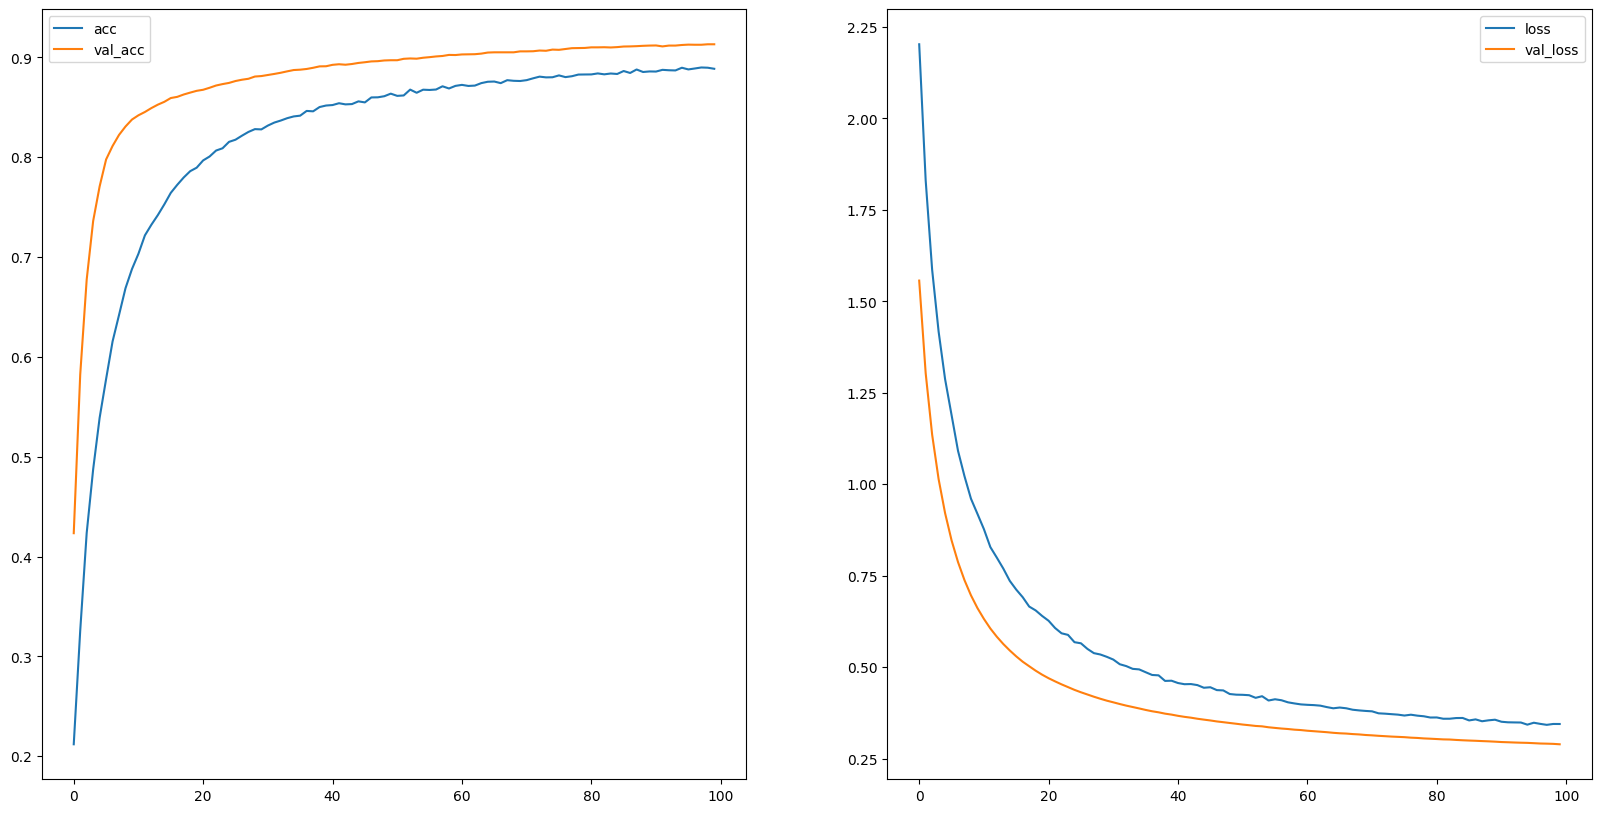

In [108]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(20, 10))

# error
fig.add_subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()

accuracy_plot_path = os.path.join(experiment_dir, 'results/plots', 'accuracy_loss_plot.png')
plt.savefig(accuracy_plot_path)

plt.show()

In [109]:
# Guarda las métricas finales, incluyendo la evaluación del conjunto de prueba, en un archivo JSON
final_metrics = {
    'final_train_accuracy': hist.history['accuracy'][-1],
    'final_val_accuracy': hist.history['val_accuracy'][-1],
    'final_train_loss': hist.history['loss'][-1],
    'final_val_loss': hist.history['val_loss'][-1],
    'test_loss': test[0],
    'test_accuracy': test[1]
}

metrics_path = os.path.join(experiment_dir, 'results', 'metrics.json')
with open(metrics_path, 'w') as metrics_file:
    json.dump(final_metrics, metrics_file)

print(f"Experiment {experiment_name} completed and saved in {experiment_dir}")

Experiment experiment_9 completed and saved in /content/drive/MyDrive/skin-cancer/experiments/experiment_9


37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 363ms/step


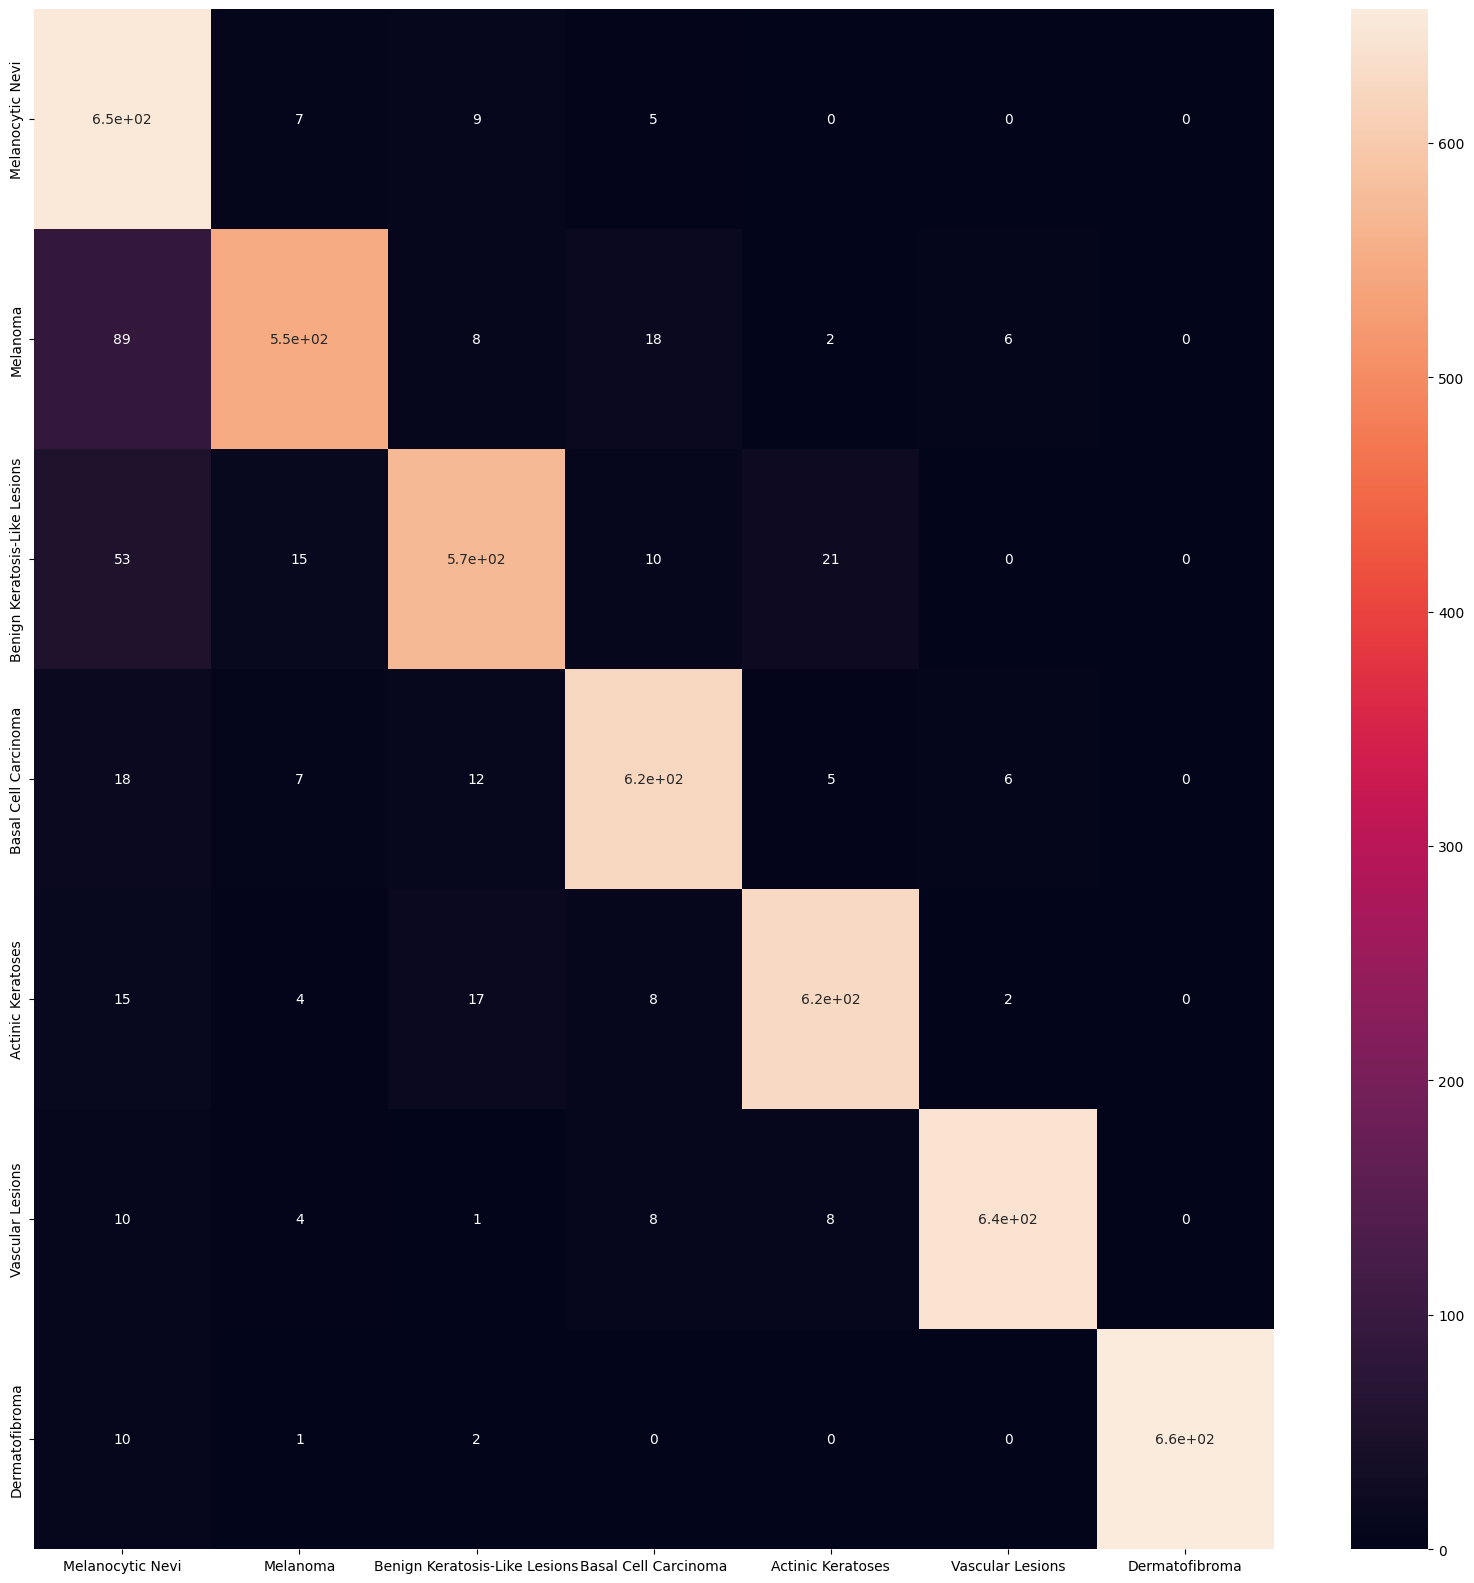

In [110]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

heatmap_path = os.path.join(experiment_dir, 'results/plots', 'heatmap.png')
plt.savefig(heatmap_path)